## PyTorch Model Optimization with Opacus

First we construct a PyTorch model.  We're writing these examples as neural networks.  The first example below, however, reduces to the logisitic regression we were using in last weeks DP-SGD example.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ExampleLogisticModule(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
        
    def forward(self, x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x[:,0]

# class ExampleLogisticModule(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         internal_size = 5
#         self.linear1 = nn.Linear(input_size, internal_size)
#         self.linear2 = nn.Linear(internal_size, 1)
#
#     def forward(self, x):
#         x = self.linear1(x)
#         x = torch.sigmoid(x)
#         x = self.linear2(x)
#         # x = torch.sigmoid(x)
#         return x


/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next we load in our data.  We're again using one of our Census PUMS examples, however, switch the variables to predict employment status as a function of education and disability status (it's a stronger relationship than our previous model of marital status).  Note how the dataset is constructed for PyTorch as a pair of tensor objects.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
data = pd.read_csv(
    "https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/MaPUMS5full.csv")


# employed ~ educ + disability

dataset = TensorDataset(
    torch.tensor(data[['educ', 'disability']].values).float(),
    torch.tensor(data['employed'].values).float())


Here we show both how to train without preserving privacy (as below), and how to add a privacy-preserving optimizer (commented out) with Opacus.  

We add a "privacy engine" and then assign privacy-preserving parameters to that engine.   This swaps PyTorch's optimizer for a DP optimizer, in this case DP-SGD.  Note the `noise_multiplier` parameter which maps to a standard deviation in the Gaussian mechanism, and the `max_grad_norm` which sets the clipping size.

/root/venv/lib/python3.7/site-packages/opacus/privacy_engine.py:101: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Text(0, 0.5, 'loss')

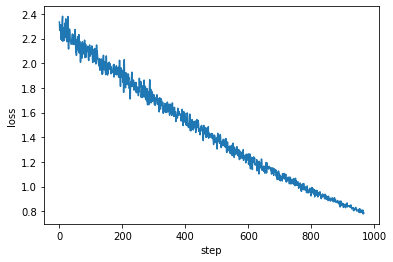

In [ ]:
from opacus import PrivacyEngine

torch.manual_seed(123)

model = ExampleLogisticModule(input_size=2)
data_loader = DataLoader(dataset, batch_size=1_000, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(), lr=.002)

num_epochs = 1

num_epochs = 4
privacy_engine = PrivacyEngine()
model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=data_loader,
    noise_multiplier=1.0,
    max_grad_norm=0.5,
)

losses = []


for _ in range(num_epochs):
    for batch in data_loader:

        # set .grad in all parameter tensors
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.binary_cross_entropy(outputs, targets)
        loss.backward()

        # take a step forward
        optimizer.step()

        # clear .grad in all parameter tensors
        optimizer.zero_grad()

        # evaluate performance
        # accuracy = torch.sum(outputs.round() == targets) / len(outputs)
        losses.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.xlabel("step")
plt.ylabel("loss")

Opacus gives us this utility to determine the total privacy-loss from the optimization steps as an accounting procedure after the run.

In [ ]:
privacy_engine.get_epsilon(delta=1e-6)

1.3203429108526712

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0df97151-1c38-49bc-a037-2a058b96fd82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>